In [2]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchsummary import summary
from torch.utils.data.dataset import Subset
from torch import nn

# Download and extract the data

In [4]:
import urllib.request
urllib.request.urlretrieve("https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz", "carpet.tar.xz")

import tarfile

with tarfile.open('carpet.tar.xz') as f:
    f.extractall('.')


# "bottle": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz",
# "cable": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937413-1629951498/cable.tar.xz",
# "capsule": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz",
# "carpet": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz",
# "grid": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937487-1629951814/grid.tar.xz",
# "hazelnut": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz",
# "leather": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937607-1629951964/leather.tar.xz",
# "metal_nut": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz",
# "pill": "https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz",
# "screw": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz",
# "tile": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938133-1629953189/tile.tar.xz",
# "toothbrush": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938134-1629953256/toothbrush.tar.xz",
# "transistor": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz",
# "wood": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938383-1629953354/wood.tar.xz",
# "zipper": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938385-1629953449/zipper.tar.xz"


# Visualize some samples

In [24]:
import matplotlib.pyplot as plt
from PIL import Image # here you can use cv2.imread/ skimage instead of PIL.Image.open

image_path = 'carpet/test/hole/000.png'
image = Image.open(image_path)
print(image.size)
print("min and max pixel values: ", np.min(image), np.max(image))

(1024, 1024)
min and max pixel values:  11 255


torch.Size([3, 224, 224])


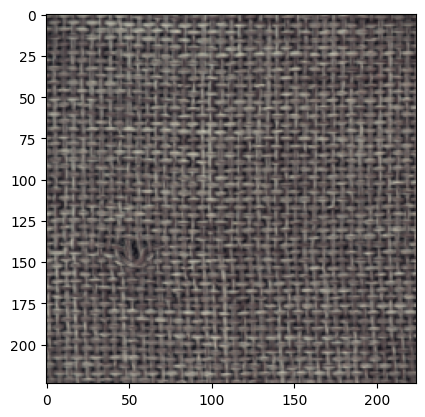

In [6]:
from torchvision.transforms import transforms

# Define the transformation pipeline using torchvision.transforms.Compose
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()          # Convert the image to a PyTorch tensor and divide by 255.0
])

# Assuming 'image' is a PIL image object
# Apply the defined transformation pipeline to the image
image = transform(image)

# Print the shape of the transformed image tensor
print(image.shape)

# Plot the transformed image
# Permute the dimensions to (height, width, channels) as matplotlib expects
plt.imshow(image.permute(1, 2, 0))
plt.show()


## Memory consumed by the tensor

In [7]:
# Calculate the memory usage
memory_usage = image.numel() * image.element_size()

# Print the memory usage
print(f"Memory usage of the tensor: {memory_usage * 279//1024} KB") # 279 is the number of samples we have in the dataset

Memory usage of the tensor: 164052 KB


In [8]:
from torchvision.datasets import ImageFolder

# Define the path to the directory containing the train images
train_image_path = 'carpet/train'

# Load the train dataset using the ImageFolder dataset class
# ImageFolder is a PyTorch dataset class for loading images from a directory
# It automatically loads images from subdirectories and applies transformations to them
# In this case, 'transform' is a transformation applied to each image in the dataset
# It preprocesses the images before they are used for training
good_dataset = ImageFolder(root=train_image_path, transform=transform)

# Access a sample from the dataset
# In this case, we're accessing the first sample
# x contains the preprocessed image data
# y contains the corresponding label (class index)
x, y = good_dataset[0]

# Print the shape of the preprocessed image data (x) and its corresponding label (y)
print("Image Shape:", x.shape)
print("Label:", y)


Image Shape: torch.Size([3, 224, 224])
Label: 0


# Train test split for the autoencoder

In [11]:
import torch

# Split the dataset into training and testing subsets
# The `torch.utils.data.random_split` function randomly splits a dataset into non-overlapping subsets
# The first argument `good_dataset` is the dataset to be split
# The second argument `[0.8, 0.2]` specifies the sizes of the subsets. Here, 80% for training and 20% for testing.

train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Print the lengths of the original dataset, training subset, and testing subset
print("Total number of samples in the original dataset:", len(good_dataset))
print("Number of samples in the training subset:", len(train_dataset))
print("Number of samples in the testing subset:", len(test_dataset))

Total number of samples in the original dataset: 280
Number of samples in the training subset: 224
Number of samples in the testing subset: 56


## Using dataloader for efficient data loading during training

In [12]:
import torch
from torch.utils.data import DataLoader

# Assuming train_dataset and test_dataset are PyTorch datasets containing image data and labels

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

# Get a batch of images and labels from the training loader
image_batch, label_batch = next(iter(train_loader))

# Print the shape of the input images and labels
print(f'Shape of input images: {image_batch.shape}')
print(f'Shape of labels: {label_batch.shape}')
# Calculate the memory usage
memory_usage = image_batch.numel() * image_batch.element_size()

# Print the memory usage
print(f"Memory usage of the tensor: {memory_usage//1024} KB")

Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB


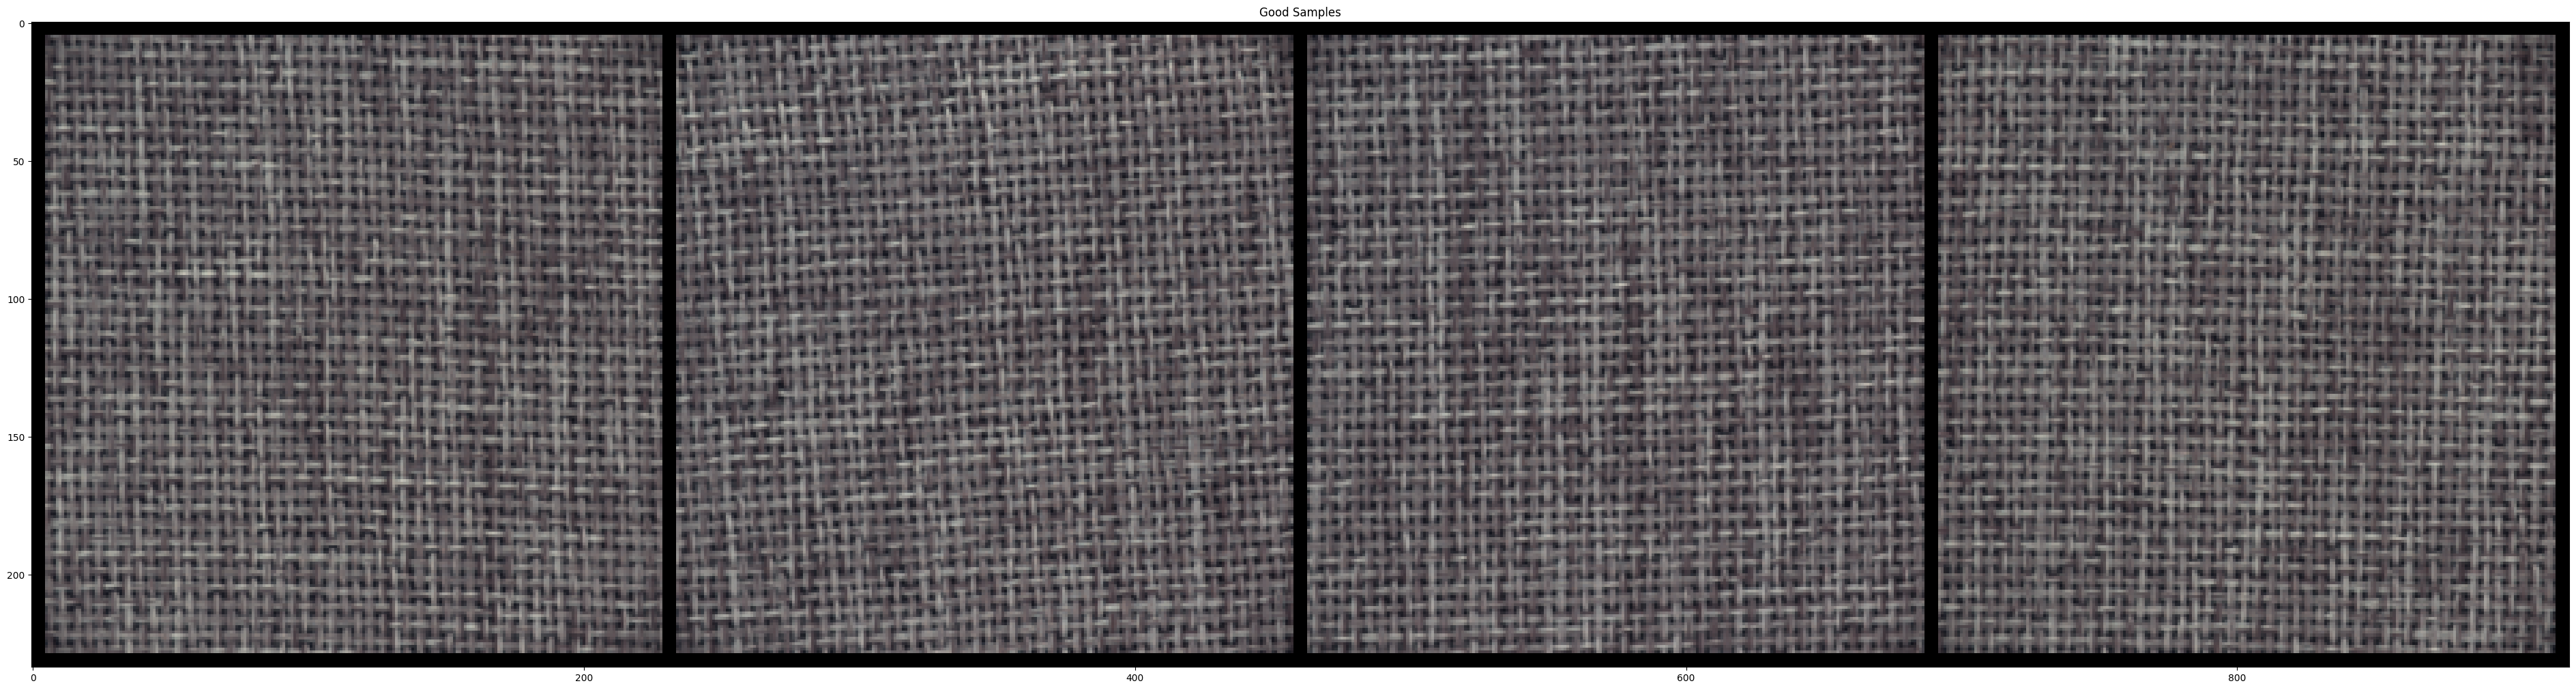

In [13]:
# Set the figure size
plt.figure(figsize=(12*4, 48*4))

# Create a grid of images from the image batch and visualize it
grid = torchvision.utils.make_grid(image_batch[0:4], padding=5, nrow=4)
plt.imshow(grid.permute(1, 2, 0))  # Permute dimensions to (height, width, channels) for visualization
plt.title('Good Samples')  # Set the title of the plot
plt.show()  # Show the plot

# Train autoencoder model

In [14]:
# Define the transformation pipeline using torchvision.transforms.Compose
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()          # Convert the image to a PyTorch tensor and divide by 255.0
])

In [15]:
import torch.nn.functional as F
from torch import nn

#input_image = Image.open(r'F:\mvtec_anomalydetection\carpet\train\good\000.png')
# Generate an empty input PIL image with 4 channels and a height and widht of 256
#input_image = Image.new('RGBA', (256, 256))

# Generan an empty input PIL image with 8 channels and a height and width of 256
# Generate a random tensor with a shape of (8, 256, 256)
input_image = torch.rand(8, 256, 256)
# Convert the tensor to a PIL image
#input_image = transforms.ToPILImage()(input_image)
#print(input_image.size)

#input_image = transform(input_image) # resizes the image, converts to a tensor 
#print(input_image.shape)
# plt.imshow(input_image.permute(1,2,0))
# plt.show()

input_image = input_image.unsqueeze(0) # adds an extra dimension (represnting batch size)
print(input_image.shape)

c1 = nn.Conv2d(in_channels=8, out_channels=128, kernel_size=4)
x = c1(input_image)
print(x.shape)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2 )
x= ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3 )
ap3 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap3(c3(x))
print(x.shape)

c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1 )
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1 )
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=8, kernel_size=5, stride=2, output_padding=1 )
x = c6(x)
print(x.shape)

torch.Size([1, 8, 256, 256])
torch.Size([1, 128, 253, 253])
torch.Size([1, 128, 126, 126])
torch.Size([1, 256, 61, 61])
torch.Size([1, 256, 29, 29])
torch.Size([1, 256, 61, 61])
torch.Size([1, 128, 126, 126])
torch.Size([1, 8, 256, 256])


In [16]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test the autoencoder architecture
model = Autoencoder()  
input_image = torch.randn(1, 3, 224, 224)  # Sample input image
output_image = model(input_image)
print(output_image.shape)  # Print the shape of the output image


torch.Size([1, 3, 224, 224])


In [17]:
ckpoints = torch.load('simple_autoencoder_l2_loss.pth', map_location=torch.device('cpu'))
model.load_state_dict(ckpoints)

FileNotFoundError: [Errno 2] No such file or directory: 'simple_autoencoder_l2_loss.pth'

In [18]:
# Define the loss function and optimizer

model.cuda()# Move the model to the GPU
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

# Training loop

  1%|          | 1/100 [00:14<24:31, 14.87s/it]

Epoch [1/100], Loss: 0.0147, Validation Loss: 0.0152


  6%|▌         | 6/100 [01:10<17:56, 11.46s/it]

Epoch [6/100], Loss: 0.0128, Validation Loss: 0.0124


 11%|█         | 11/100 [02:05<16:16, 10.98s/it]

Epoch [11/100], Loss: 0.0118, Validation Loss: 0.0116


 16%|█▌        | 16/100 [02:59<15:15, 10.90s/it]

Epoch [16/100], Loss: 0.0075, Validation Loss: 0.0074


 21%|██        | 21/100 [03:54<14:18, 10.87s/it]

Epoch [21/100], Loss: 0.0062, Validation Loss: 0.0060


 26%|██▌       | 26/100 [04:49<13:29, 10.94s/it]

Epoch [26/100], Loss: 0.0053, Validation Loss: 0.0052


 31%|███       | 31/100 [05:43<12:32, 10.91s/it]

Epoch [31/100], Loss: 0.0050, Validation Loss: 0.0050


 36%|███▌      | 36/100 [06:38<11:39, 10.93s/it]

Epoch [36/100], Loss: 0.0048, Validation Loss: 0.0047


 41%|████      | 41/100 [07:33<10:47, 10.97s/it]

Epoch [41/100], Loss: 0.0044, Validation Loss: 0.0045


 46%|████▌     | 46/100 [08:28<09:54, 11.01s/it]

Epoch [46/100], Loss: 0.0042, Validation Loss: 0.0044


 51%|█████     | 51/100 [09:23<09:00, 11.04s/it]

Epoch [51/100], Loss: 0.0043, Validation Loss: 0.0042


 56%|█████▌    | 56/100 [10:18<08:04, 11.01s/it]

Epoch [56/100], Loss: 0.0039, Validation Loss: 0.0041


 61%|██████    | 61/100 [11:13<07:11, 11.07s/it]

Epoch [61/100], Loss: 0.0042, Validation Loss: 0.0040


 66%|██████▌   | 66/100 [12:09<06:17, 11.11s/it]

Epoch [66/100], Loss: 0.0039, Validation Loss: 0.0038


 71%|███████   | 71/100 [13:04<05:22, 11.11s/it]

Epoch [71/100], Loss: 0.0038, Validation Loss: 0.0037


 76%|███████▌  | 76/100 [14:00<04:26, 11.09s/it]

Epoch [76/100], Loss: 0.0037, Validation Loss: 0.0037


 81%|████████  | 81/100 [14:55<03:29, 11.04s/it]

Epoch [81/100], Loss: 0.0035, Validation Loss: 0.0036


 86%|████████▌ | 86/100 [15:50<02:34, 11.05s/it]

Epoch [86/100], Loss: 0.0038, Validation Loss: 0.0037


 91%|█████████ | 91/100 [16:46<01:40, 11.12s/it]

Epoch [91/100], Loss: 0.0035, Validation Loss: 0.0034


 96%|█████████▌| 96/100 [17:41<00:44, 11.10s/it]

Epoch [96/100], Loss: 0.0034, Validation Loss: 0.0034


100%|██████████| 100/100 [18:26<00:00, 11.06s/it]


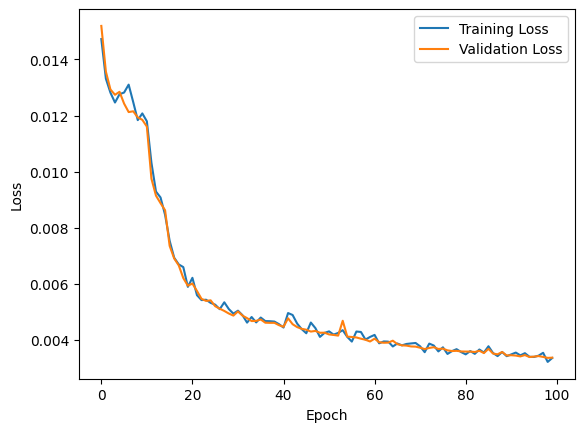

In [19]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    for img, _ in train_loader:
        img = img.cuda()
        
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() #clears the gradients of all optimized tensors.  This step is necessary because gradients are accumulated by default in PyTorch, and we want to compute fresh gradients for the current batch of data.
        loss.backward() # This line computes the gradients of the loss function with respect to the model parameters. These gradients are used to update the model parameters during optimization.
        optimizer.step() # This line updates the model parameters using the computed gradients. 
    Loss.append(loss.item())
       

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in test_loader:
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
        

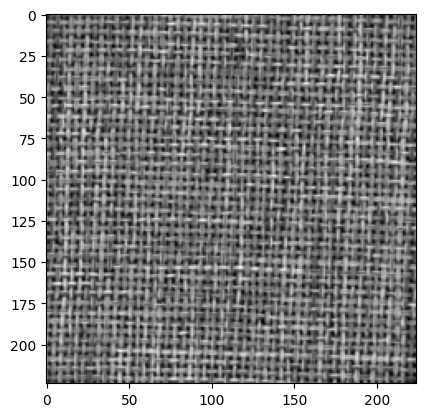

img shape: torch.Size([16, 3, 224, 224])
min and max values of the image: tensor(0.0471, device='cuda:0') tensor(0.8353, device='cuda:0')
output shape: torch.Size([16, 3, 224, 224])
min and max values of the output: tensor(0.0769, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7102, device='cuda:0', grad_fn=<MaxBackward1>)
loss shape: tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)


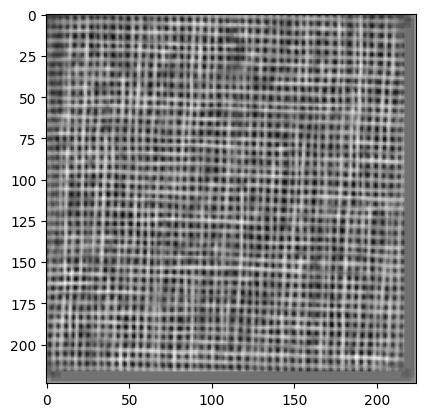

In [23]:
# Save the model
# torch.save(model.state_dict(), 'simple_autoencoder_l2_loss.pth')
# model.eval()

# ckpoints = torch.load('simple_autoencoder_l2_loss.pth')
# model.load_state_dict(ckpoints)
for idx, img in enumerate(train_loader):
    img = img[0].cuda()
    plt.imshow(img[0][0].cpu().numpy().squeeze(), cmap='gray')
    plt.show()
    output = model(img)
    plt.imshow(output[0][0].cpu().detach().numpy().squeeze(), cmap='gray')
    loss = criterion(output, img)
    print('img shape:', img.shape)
    print("min and max values of the image:", img.min(), img.max())
    print('output shape:', output.shape)
    print("min and max values of the output:", output.min(), output.max())
    print('loss shape:', loss)
    break

## Reconstruction of good images

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

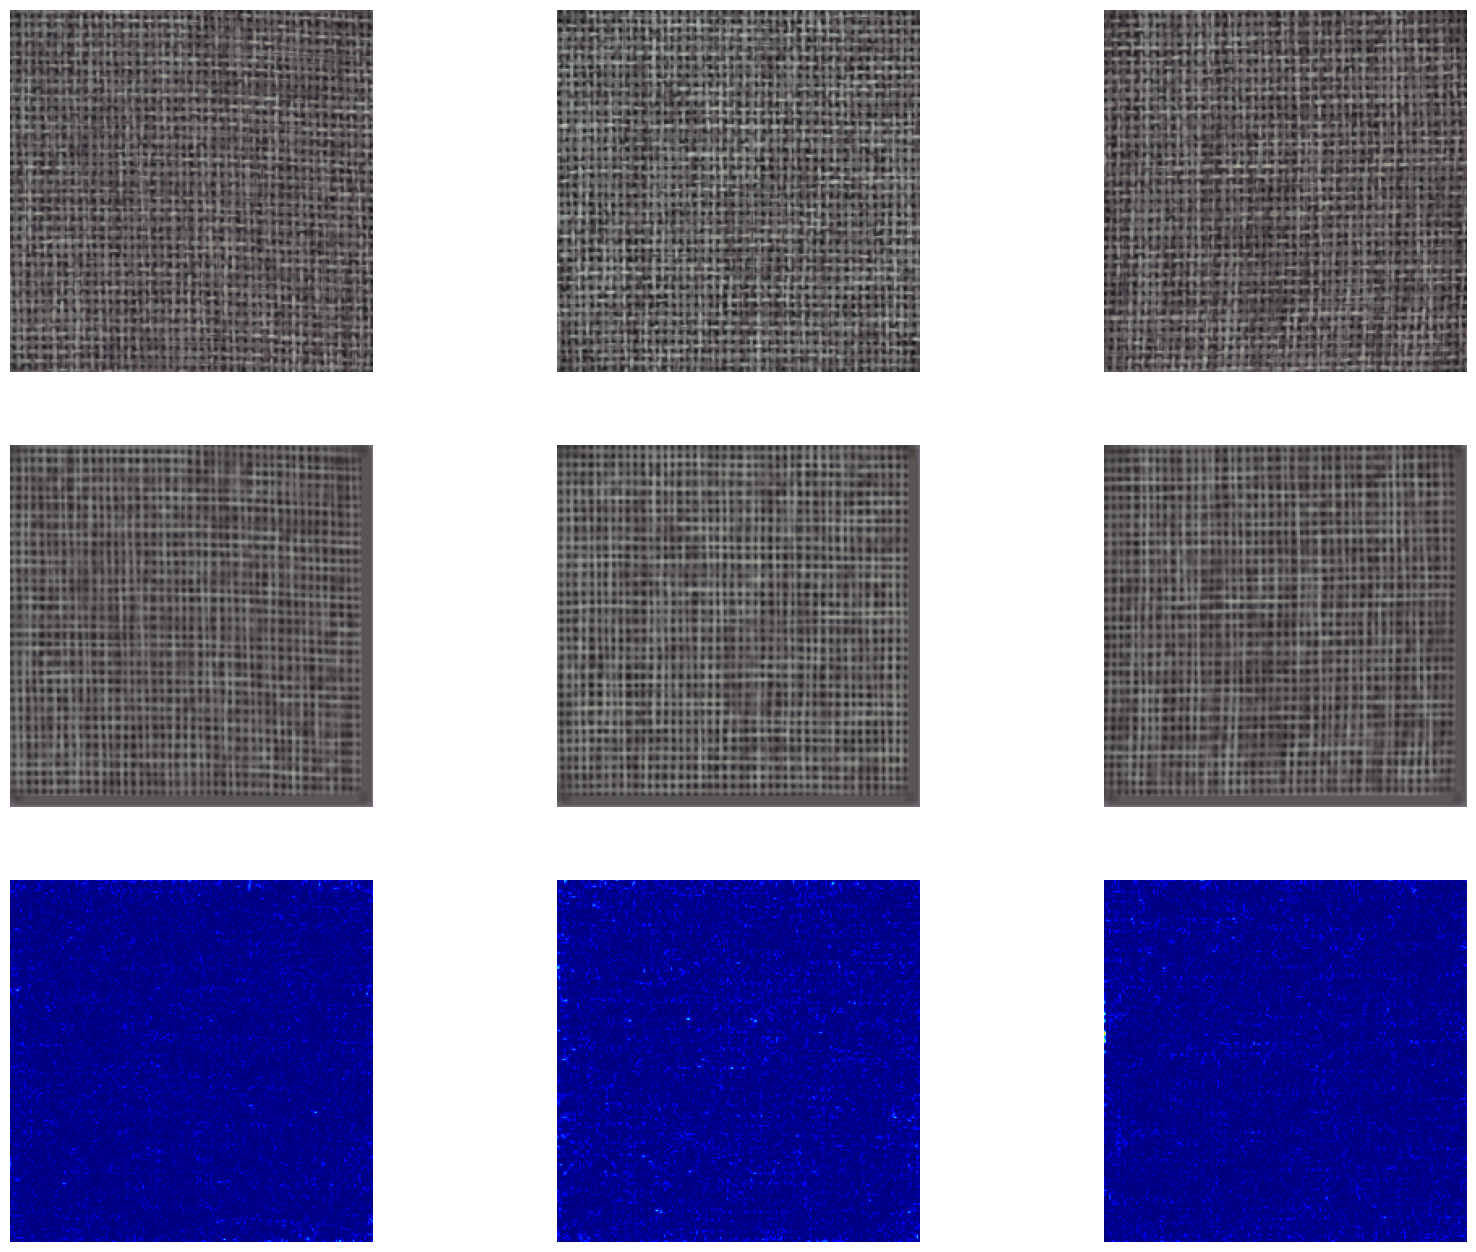

In [ ]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

## Reconstruction of bad images

# Obtain the fault detection HEATMAP using AE

<Figure size 1600x1200 with 0 Axes>

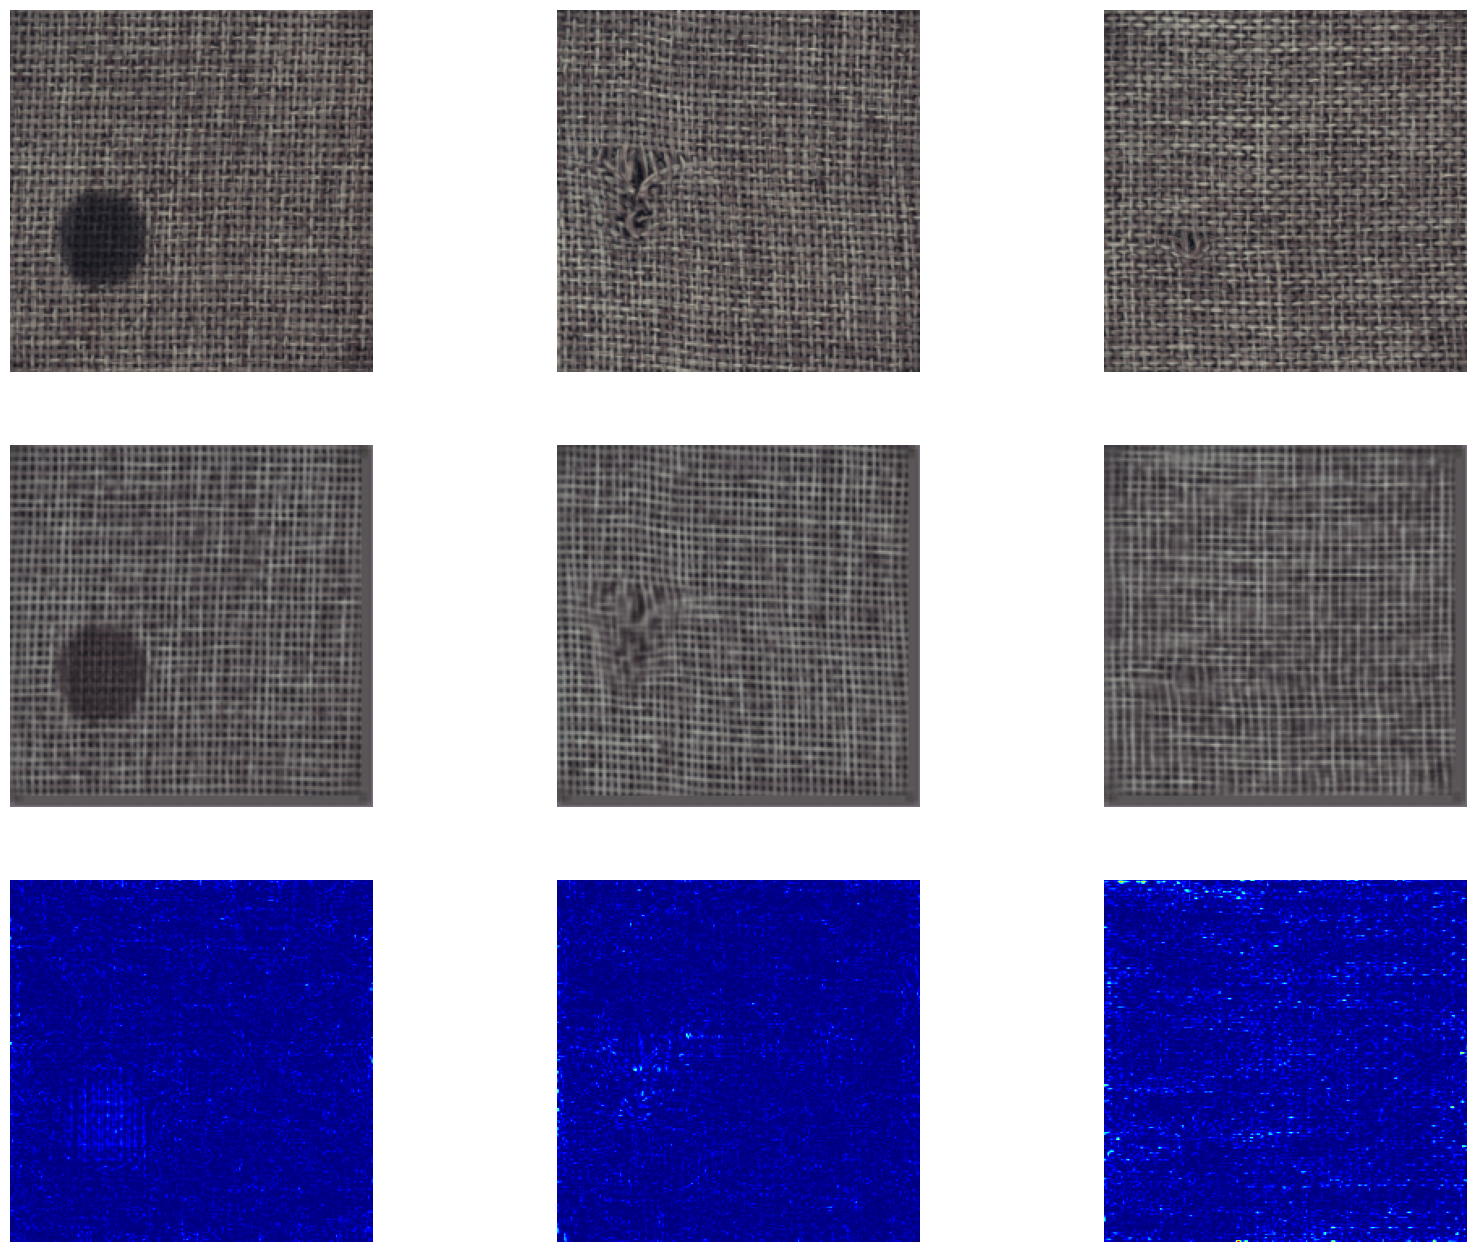

In [37]:
test_image_1 = transform(Image.open(r'F:\mvtec_anomalydetection\carpet\test\color\000.png'))
test_image_2 = transform(Image.open(r'F:\mvtec_anomalydetection\carpet\test\cut\000.png'))
test_image_3 = transform(Image.open(r'F:\mvtec_anomalydetection\carpet\test\hole\000.png'))

data = torch.stack([test_image_1,test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)
    
recon_error =  ((data-recon)**2).mean(axis=1)
    
plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()


# Obtain the fault detection accuracy

In [25]:
RECON_ERROR=[]
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        data_recon_squared_mean =  ((data-recon)**2).mean(axis=(1))[:,0:-10,0:-10].mean(axis=(1,2))
        
        RECON_ERROR.append(data_recon_squared_mean)
        
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

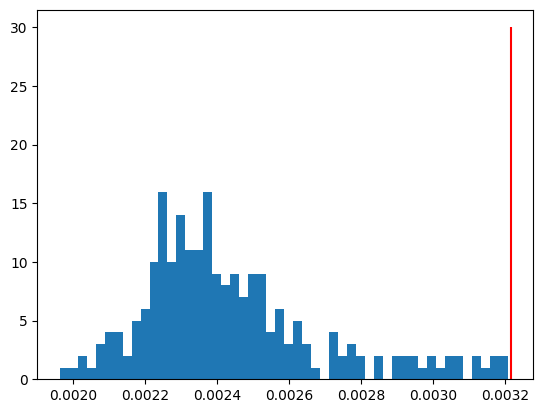

In [25]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r') 
plt.show()

In [42]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()

with torch.no_grad():

    test_path = Path('carpet/test')

    for path in test_path.glob('*/*.png'):
        fault_type = path.parts[-2]
        # if fault_type != 'good':
        test_image = transform(Image.open(path)).cuda().unsqueeze(0)
        recon_image = model(test_image)
        
        # y_score_image = 
        y_score_image =  ((test_image - recon_image)**2).mean(axis=(1))[:,0:-10,0:-10].mean()
    
        y_pred_image = 1*(y_score_image >= best_threshold)
        
        y_true_image = 0 if fault_type == 'good' else 1
        
        y_true.append(y_true_image)
        y_pred.append(y_pred_image.cpu())
        y_score.append(y_score_image.cpu())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)
    

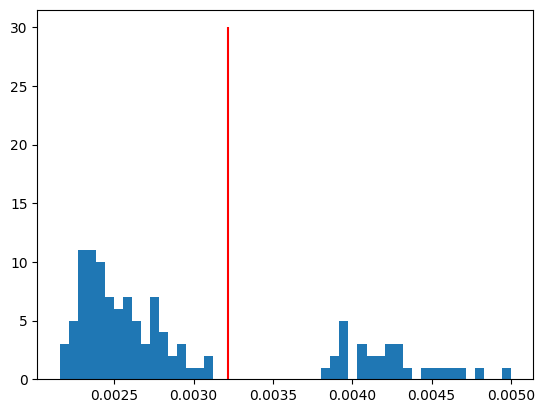

In [43]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

AUC-ROC Score: 0.4189406099518459


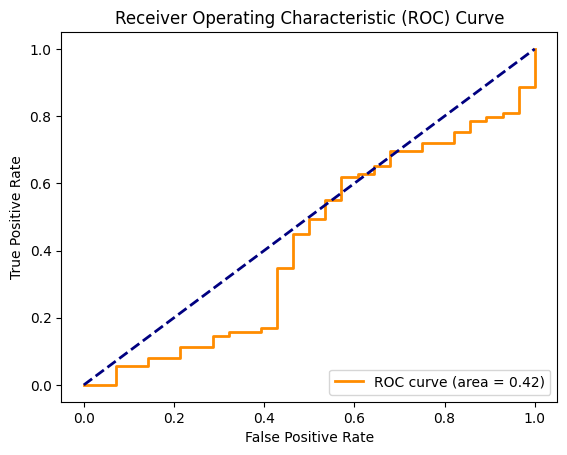

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

